In [ ]:
pip install librosa==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


## The first step is to load the WAV files, use a Python package named Librosa to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [2]:
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file,sr=None)
    ms = librosa.feature.melspectrogram(y=y, sr=sr,n_fft = 8096, hop_length=4000,n_mels=128)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create PNG files containing spectrograms from all the WAV files  of drone audio and speeches of people,in the "drone_new" and 'speeches' directory.

In [ ]:
create_pngs_from_wavs('/content/drive/MyDrive/AUDIO_KAGGLE_DATASET/drone', '/content/drive/MyDrive/DRONE_MEL')


In [ ]:
create_pngs_from_wavs('/content/drive/MyDrive/AUDIO_KAGGLE_DATASET/noise', '/content/drive/MyDrive/UNKNOWN_MEL')

## Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [10]:

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(tf.keras.utils.img_to_array(tf.keras.utils.load_img(os.path.join(path, file), target_size=(242, 241,3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

## Load the background spectrogram images, add them to the list named x, and label them with 0s.

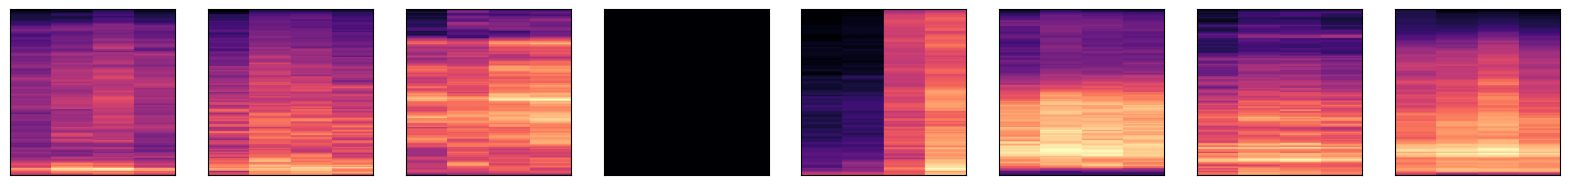

In [11]:
images, labels = load_images_from_path('/content/drive/MyDrive/UNKNOWN_MEL', 0)
show_images(images)
    
x += images
y += labels

## Load the drone spectrogram images, add them to the list named x, and label them with 1s.

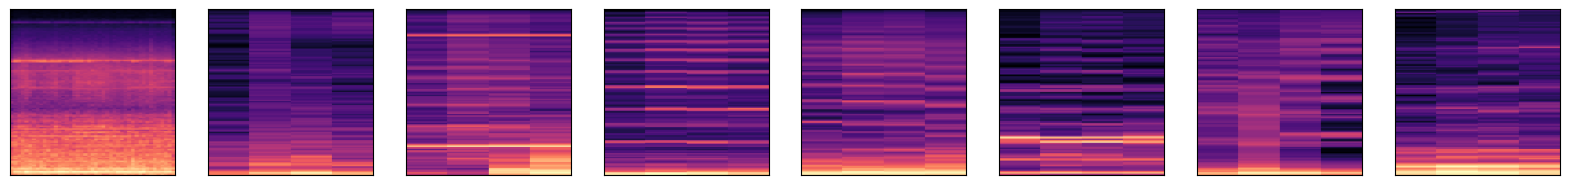

In [12]:
images, labels = load_images_from_path('/content/drive/MyDrive/DRONE_MEL', 1)
show_images(images)
    
x += images
y += labels

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

## Split the images and labels into two datasets — one for training, and one for testing. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's to_categorical function.

In [ ]:
y_train_encoded[0].shape

(2,)

In [ ]:
#x_train_norm 

# Build and train a CNN
State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with convolutional neural networks that use convolution layers to extract features from images and pooling layers to downsize images so features can be detected at various resolutions. The next task is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, and a softmax layer that outputs probabilities for each class, and to train it with spectrogram images and labels. Start by defining the CNN


In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(242, 241, 3)))
#relu is an activation function like sigmoid but works in diffetent way
#it works like if the value is positive it return 1 other wise it returns 0 
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))


model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(242, 241, 3)))#add dropout
model.add(Dense(2, activation='sigmoid')) 
#sigmoid
#change adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 240, 239, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 120, 119, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 118, 117, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 59, 58, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 57, 56, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 64)      

## Train the CNN and save the history object returned by fit in a local variable.

In [19]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=80, epochs=10)


Epoch 1/10
18/18 [==============================] - 158s 9s/step - loss: 0.6882 - accuracy: 0.6976 - val_loss: 0.3497 - val_accuracy: 0.8700
Epoch 2/10
18/18 [==============================] - 149s 8s/step - loss: 0.2889 - accuracy: 0.8799 - val_loss: 0.1787 - val_accuracy: 0.9417
Epoch 3/10
18/18 [==============================] - 151s 8s/step - loss: 0.2102 - accuracy: 0.9092 - val_loss: 0.2171 - val_accuracy: 0.9083
Epoch 4/10
18/18 [==============================] - 151s 8s/step - loss: 0.1680 - accuracy: 0.9378 - val_loss: 0.1364 - val_accuracy: 0.9467
Epoch 5/10
18/18 [==============================] - 147s 8s/step - loss: 0.1225 - accuracy: 0.9514 - val_loss: 0.1218 - val_accuracy: 0.9617
Epoch 6/10
18/18 [==============================] - 150s 8s/step - loss: 0.0967 - accuracy: 0.9664 - val_loss: 0.1123 - val_accuracy: 0.9650
Epoch 7/10
18/18 [==============================] - 148s 8s/step - loss: 0.0886 - accuracy: 0.9693 - val_loss: 0.1012 - val_accuracy: 0.9650
Epoch 8/10
18

In [20]:
model.save("/content/drive/MyDrive/my_model.h5")

[]

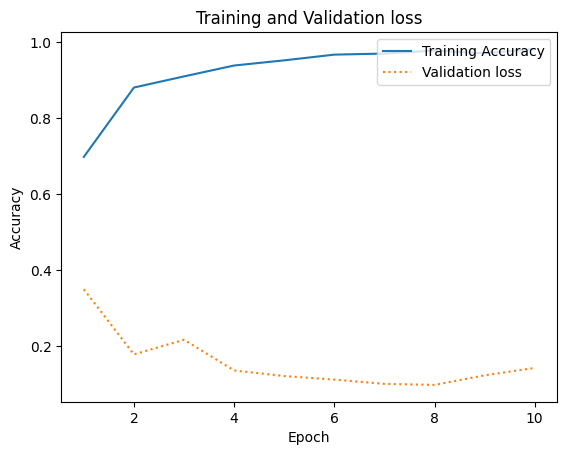

In [21]:
ffacc = hist.history['accuracy']
val_loss = hist.history['val_loss']
epochs = range(1, len(ffacc) + 1)

plt.plot(epochs, ffacc, '-', label='Training Accuracy')
plt.plot(epochs, val_loss, ':', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.plot()
#training and validdation loss plot 
#overfitting and undersfitting acc to training accuracy andf validation accuracy

[]

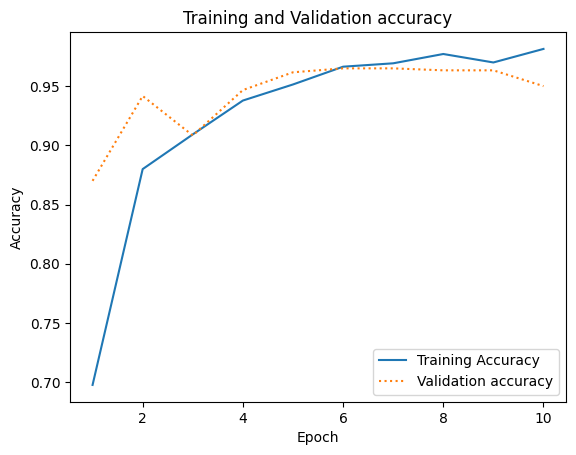

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:

# score = model.evaluate(x_test_norm, y_test_encoded, verbose=1)
# accuracy = 100*score[1]

# print("Pre-training accuracy: %.4f%%" % accuracy)

In [23]:
score = model.evaluate(x_train_norm, y_train_encoded, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test_norm, y_test_encoded, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9799857139587402
Testing Accuracy:  0.949999988079071


# testing any audio


In [35]:
create_spectrogram('/content/drive/MyDrive/DREGON_hovering_nosource_room2.wav', '/content/drive/MyDrive/sample9.png')

In [36]:
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# load the saved model
model = load_model('/content/drive/MyDrive/my_model.h5')

def predict_image_class(spectrogram_path):
    # load the image
    img = tf.keras.utils.load_img(spectrogram_path, target_size=(242, 241,3))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # normalize the pixel values

    # make prediction
    prediction = model.predict(img_array)

    # return the predicted class
    if prediction[0][0] > prediction[0][1]:
        return 'The image is class 0 or noise'
    else:
        return 'The image is class 1 or drone'

# use the sample9.png image for prediction
result = predict_image_class('/content/drive/MyDrive/sample9.png')
print(result)


1/1 [==============================] - 0s 176ms/step
The image is class 1 or drone
